In [1]:
from imports import *
import Utils
import pickle
import scipy

try:
    %load_ext autoreload
    %autoreload 2
    
except:
    pass

C:\Users\leetw\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read and Reshape Data

#### Training Data

In [2]:
# params
BATCH_SIZE = 8

In [3]:
# read data
try:
    images, binary_masks, contours_masks, colored_masks = Utils.read_all_training_data()
except:
    path = "input/stage1_train/"
    images, binary_masks, contours_masks, colored_masks = Utils.create_all_data(path, use_masks=True)
    
    filepath = "pickles/train_images.p"
    pickle.dump(images, open(filepath, "wb"))

    filepath = "pickles/train_binary_masks.p"
    pickle.dump(binary_masks, open(filepath, "wb"))

    filepath = "pickles/train_contours_masks.p"
    pickle.dump(contours_masks, open(filepath, "wb"))

    filepath = "pickles/train_colored_masks.p"
    pickle.dump(colored_masks, open(filepath, "wb"))

In [4]:
# reshape data
images, shapes_orig = Utils.reshape_all_images_and_save_orig_shapes(images, new_size=(256, 256))
binary_masks, binary_shapes_orig = Utils.reshape_all_images_and_save_orig_shapes(binary_masks, new_size=(256, 256))
contours_masks, _ = Utils.reshape_all_images_and_save_orig_shapes(contours_masks, new_size=(256, 256))
colored_masks, _ = Utils.reshape_all_images_and_save_orig_shapes(colored_masks, new_size=(256, 256))

In [5]:
# verify new shapes
_ = Utils.get_all_data_shapes(images, verbose=1)
_ = Utils.get_all_data_shapes(binary_masks, verbose=1)

(256, 256, 3)    664
dtype: int64
(256, 256)    664
dtype: int64


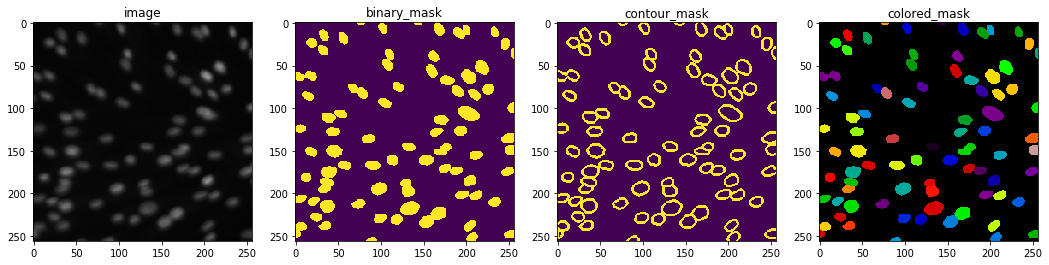

In [6]:
# plot example
i = 12
Utils.plot_list_of_images_in_a_row([images[i], binary_masks[i], contours_masks[i], colored_masks[i]], 
                                 ["image", "binary_mask", "contour_mask", "colored_mask"])

In [7]:
# split train/test
idx_train, idx_test, _, _ = train_test_split(np.arange(len(images)), np.arange(len(images)), test_size=0.1, random_state=42)
idx_train, idx_val, _, _ = train_test_split(np.arange(len(idx_train)), np.arange(len(idx_train)), test_size=0.1, random_state=42)


shapes_train = shapes_orig[idx_train]
shapes_test = shapes_orig[idx_test]
shapes_val = shapes_orig[idx_val]

images_train = images[idx_train]
images_test = images[idx_test]
images_val = images[idx_val]

binary_masks_train = binary_masks[idx_train]
binary_masks_test = binary_masks[idx_test]
binary_masks_val = binary_masks[idx_val]


contours_masks_train = contours_masks[idx_train]
contours_masks_test = contours_masks[idx_test]
contours_masks_val = contours_masks[idx_val]


colored_masks_train = colored_masks[idx_train]
colored_masks_test = colored_masks[idx_test]
colored_masks_val = colored_masks[idx_val]

### Create Image Generators

In [8]:
data_gen_args_img = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2, 
                     fill_mode="reflect")

data_gen_args_msk = dict(rotation_range=90.,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2, 
                     fill_mode="reflect")

# data_gen_args_img = dict( # for comapring
#                      rotation_range=90.,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      fill_mode="constant", cval=1)

# data_gen_args_msk = dict(rotation_range=90.,# for comapring
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      fill_mode="constant", cval=1)

def create_generators_pair(X, Y, seed=0):
    image_datagen = ImageDataGenerator(**data_gen_args_img)
    mask_datagen = ImageDataGenerator(**data_gen_args_msk)
    Y = np.expand_dims(Y,axis=3)
    
    image_datagen.fit(X, augment=True, seed=seed)
    mask_datagen.fit(Y, augment=True, seed=seed)

    image_generator = image_datagen.flow(X, seed=seed, batch_size=BATCH_SIZE, shuffle=True)
    mask_generator = mask_datagen.flow(Y, seed=seed, batch_size=BATCH_SIZE, shuffle=True)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    return image_generator, mask_generator, train_generator



In [9]:
# compare generators
def compre_generators_image_mask(image_generator, mask_generator, n=10):
    for i in range(n):
        x = image_generator.next()[0]
        x = (x-x.min())/(x-x.min()).max()
        y = mask_generator.next()[0]
        print(x.shape, x.max(), x.min())
        print(y.shape, y.max(), y.min())
        fig = plt.figure()
        Utils.plot_list_of_images_in_a_row([x, y])

#### generator for masks-model

In [10]:
image_generator_train1, mask_generator_train1, generator_train1 = create_generators_pair(images_train, binary_masks_train)
image_generator_val1, mask_generator_val1, generator_val1 = create_generators_pair(images_val, binary_masks_val)

In [11]:
# compre_generators_image_mask(image_generator_train1, mask_generator_train1, n=10)

In [12]:
# compre_generators_image_mask(image_generator_val1, mask_generator_val1, n=10)

#### generator for contours-model

In [13]:
image_generator_train2, mask_generator_train2, generator_train2 = create_generators_pair(images_train, contours_masks_train)
image_generator_val2, mask_generator_val2, generator_val2 = create_generators_pair(images_val, contours_masks_val)

In [14]:
# compre_generators_image_mask(image_generator_train2, mask_generator_train2, n=10)

In [15]:
# compre_generators_image_mask(image_generator_val2, mask_generator_val2, n=10)

### Train Models:

In [16]:
UNET_DEPTH = 6
UNET_INIT_FILTERS = 16

LR_INIT = 1e-4
LR_MIN = 1e-9
LR_REDUCE_FACTOR = 0.5
PATIENCE = 10

#### Masks Model

In [17]:
unet = myUnetHP()
model_masks = unet.build(n_depth_layers=UNET_DEPTH, n_init_filters=UNET_INIT_FILTERS, x_max=1.)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l0_input (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
l0_normalize (Lambda)           (None, 256, 256, 3)  0           l0_input[0][0]                   
__________________________________________________________________________________________________
enc_l1_1c (Conv2D)              (None, 256, 256, 16) 448         l0_normalize[0][0]               
__________________________________________________________________________________________________
enc_l1_2c (Conv2D)              (None, 256, 256, 16) 2320        enc_l1_1c[0][0]                  
__________________________________________________________________________________________________
enc_l1_3p 

In [ ]:
# Compile model:
model_masks.compile(optimizer=Adam(lr = LR_INIT), loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
checkpointer = ModelCheckpoint('saved_models/model_masks-nuclei2018-1.h5', verbose=1, save_best_only=True) # todo: automatic names
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=LR_REDUCE_FACTOR, patience=PATIENCE, min_lr=LR_MIN, verbose=1) # search "learning rate"

In [18]:
### read init weights

# model_weights_path = "model-nuclei2018-2-dph%d_flts%d.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
model_weights_path = "saved_models/model_masks-nuclei2018-85miou.h5"
# model_weights_path = "model-nuclei2018-3-dph%d_flts%d_epochs30000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
if os.path.isfile(model_weights_path):
    model_masks.load_weights(model_weights_path)

In [ ]:
# plot loss/miou to graph instead of text

results = model_masks.fit_generator(generator_train1, epochs=10000, validation_data=generator_val1, callbacks=[checkpointer, reduce_lr],
                              steps_per_epoch=images_train.shape[0]//BATCH_SIZE, 
                              validation_steps=images_val.shape[0]//BATCH_SIZE, 
                              verbose=1)

In [ ]:
model_masks.save_weights("saved_models/model_masks-nuclei2018-85miou.h5")

#### Contours Model

In [19]:
unet = myUnetHP()
model_contours = unet.build(n_depth_layers=UNET_DEPTH, n_init_filters=UNET_INIT_FILTERS, x_max=1.)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l0_input (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
l0_normalize (Lambda)           (None, 256, 256, 3)  0           l0_input[0][0]                   
__________________________________________________________________________________________________
enc_l1_1c (Conv2D)              (None, 256, 256, 16) 448         l0_normalize[0][0]               
__________________________________________________________________________________________________
enc_l1_2c (Conv2D)              (None, 256, 256, 16) 2320        enc_l1_1c[0][0]                  
__________________________________________________________________________________________________
enc_l1_3p 

In [ ]:
# Compile model:
model_contours.compile(optimizer=Adam(lr = LR_INIT), loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
checkpointer = ModelCheckpoint('model_contours-nuclei2018-1.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=LR_REDUCE_FACTOR, patience=PATIENCE, min_lr=LR_MIN, verbose=1) # search "learning rate"

In [20]:
# model_weights_path = "model-nuclei2018-2-dph%d_flts%d.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
# model_weights_path = "model_contours-nuclei2018-1.h5"
model_weights_path = "saved_models/model_contours-nuclei2018-91miou.h5"
# model_weights_path = "model-nuclei2018-3-dph%d_flts%d_epochs30000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
if os.path.isfile(model_weights_path):
    model_contours.load_weights(model_weights_path)

In [ ]:
results = model_contours.fit_generator(generator_train2, epochs=10000, validation_data=generator_val2, callbacks=[checkpointer, reduce_lr],
                              steps_per_epoch=images_train.shape[0]//BATCH_SIZE, 
                              validation_steps=images_val.shape[0]//BATCH_SIZE, 
                              verbose=1)

In [ ]:
model_contours.save_weights("saved_models/model_contours-nuclei2018-91miou.h5") # fill miou

### predict

In [21]:
range_index = range(19,22)

In [22]:
mask_prediction = (model_masks.predict(images_test[range_index])>0.4).astype(int)
contour_prediction = (model_contours.predict(images_test[range_index])>0.3).astype(int)

In [23]:
#  add otsu threshold
#  plot few thresholds

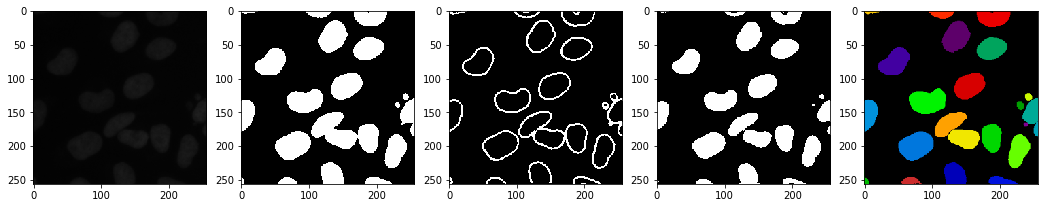

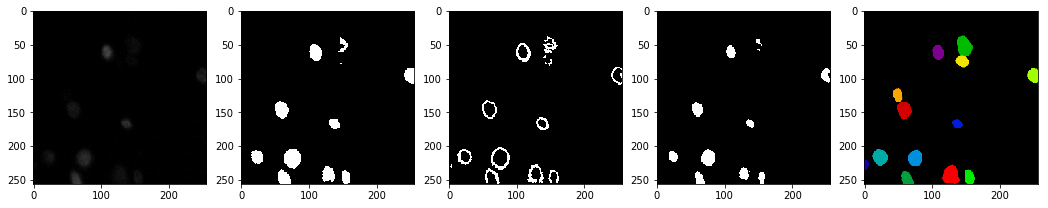

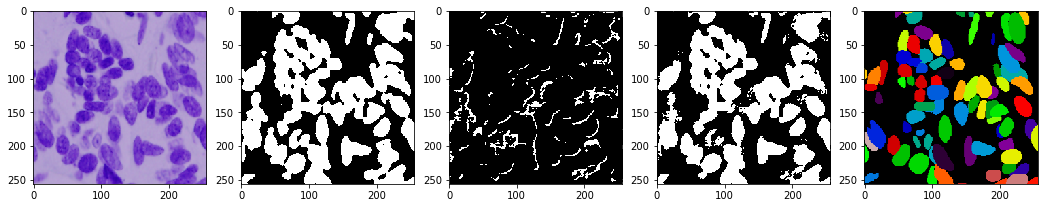

In [24]:
for i in range_index:
#     plt.figure
    diff = np.maximum(np.zeros(mask_prediction[i-range_index[0]].shape), (mask_prediction[i-range_index[0]] - contour_prediction[i-range_index[0]]))
    Utils.plot_list_of_images_in_a_row([images_test[i], mask_prediction[i-range_index[0]], contour_prediction[i-range_index[0]], diff, colored_masks_test[i]])
#     Utils.plot_list_of_images_in_a_row([images_test[i], mask_prediction[i-range_index[0]], contour_prediction[i-range_index[0]], colored_masks_test[i]])

### Post-Processing (Masks+Contours)

### Evaluate Performance

### Prepare Submission

#### binary-mask to multiple masks

In [44]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5): # X is colored mask
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

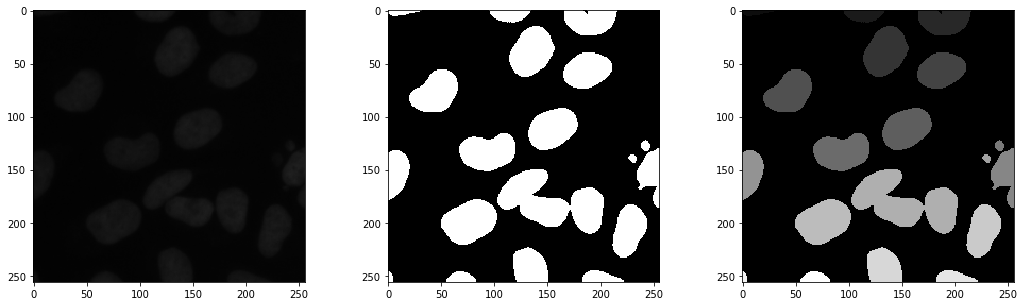

In [54]:
example_index = 0
predict_example = mask_prediction[example_index]
original_example = images_test[range_index[example_index]]

# separated_masks = Utils.from_binary_mask_to_masks(predict_example)
# print(len(separated_masks), separated_masks[0].shape)
# colored_out = Utils.from_binary_masks_to_colored_mask(separated_masks)

colored_out, num_labels = scipy.ndimage.label(predict_example)
Utils.plot_list_of_images_in_a_row([original_example, predict_example, colored_out])

In [ ]:

# for i in range(len(separated_masks)//4+1):
#     Utils.plot_list_of_images_in_a_row(separated_masks[4*i:4*i+4])

In [ ]:
topDir = "C:/Users/leetw/PycharmProjects/PathoProject/Anomaly-Segmentation(U-Net)/input"

test_path = os.path.join(topDir, 'stage1_test')   #path to test data file/folder
Y_hat = cv2.imread("C:/Users/leetw/Desktop/yin-and-yang.png") # todo: should be list of predictions matching test samples

In [45]:

Y_hat = colored_out

# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
# for n, id_ in enumerate(os.listdir(test_path)):
for n, id_ in enumerate(os.listdir(test_path)): # zip(paths, predicts)
    rle = list(prob_to_rles(Y_hat))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

260

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: {}/working/sub-{}.csv'.format(topDir, timestamp))
sub.to_csv(topDir+"/working/sub-{}.csv".format(timestamp), index=False)

In [ ]:
# Have a look at our submission pandas dataframe
sub.head()

In [ ]:
# for-loop over: Utils.from_binary_mask_to_masks(mask)

In [ ]:
a[0].shape

In [ ]:
idx_test[19]

In [ ]:
from glob import glob
glob("input/stage1_train/*")[155]

In [29]:
mask_prediction.shape

(3, 256, 256, 1)

In [30]:
contour_prediction.shape

(3, 256, 256, 1)